### Imports

In [1]:
import os
import random
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import tensorflow as tf
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape
from keras.layers import Activation, BatchNormalization, LeakyReLU, Dropout, MaxPool2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam, RMSprop, Adagrad, SGD
from keras.utils import plot_model
from skimage.io import imread
from PIL import Image, ImageDraw
import cv2 as cv
import math
import h5py
from keras.models import load_model
import json
# from google.colab.patches import cv2_imshow

### Data

The data we are using is [Flickr-Faces-HQ Dataset (FFHQ)](https://github.com/NVlabs/ffhq-dataset). It is an unlabelled dataset used for training GANs and other image generation algorithms. The original dataset has images of size 1024 by 1024 but we have only taken 128 by 128 images.

In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# zip_file_path = '/content/drive/MyDrive/Multimodal Project/finals/small_data.zip'

In [4]:
# extract_path = '/Users/raviagrawal/Desktop/CSCI 535/Final Project/small_data'

In [5]:
# import zipfile

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

In [2]:
import os
from glob import glob
import numpy as np

# data folder path in colab runtime environment
DATA_FOLDER = '/Users/raviagrawal/Desktop/CSCI 535/Final Project/small_data'

# Fetching all the filenames for images from folder 00000 with names 00000.png to 00999.png
filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.png')))
# Total images in the directory
NUM_IMAGES = len(filenames)
print("Total number of images: " + str(NUM_IMAGES))


Total number of images: 54000


### Data Generator

In [3]:
def draw_square_on_image(image):

    output_img = image

    random_start_point = np.random.randint(0,100)
    img_draw = ImageDraw.Draw(output_img)
    img_draw.rectangle([(random_start_point,random_start_point),(random_start_point+28,random_start_point+28)], fill='black')

    return np.array(output_img)

In [4]:
def custom_image_generator(files, data_instances, batch_size = 64):


    iter = 0

    while True:


        if (iter*batch_size + batch_size) > len(files):
          iter= 0

        end_iter = iter*batch_size + batch_size


        paths = files[iter*batch_size:end_iter]

        corrupted_images_batch = []
        original_images_batch = []
        for path in paths:
          img =  Image.open(path)
          original_images_batch.append(np.array(img)/255)
          masked_img = draw_square_on_image(img)
          preprocess_img = np.array(masked_img)
          corrupted_images_batch.append(preprocess_img/255)



        corrupted_images_batch = np.array(corrupted_images_batch)
        original_images_batch = np.array(original_images_batch)


        iter = iter + 1


        yield (corrupted_images_batch, original_images_batch)

Utility function to display grid of images.

In [5]:
def display_image_grid1(images, num_rows, num_cols, title_text):

    fig = plt.figure(figsize=(num_cols*3., num_rows*3.), )
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

    for ax, im in zip(grid, images):
        ax.imshow(im)
        ax.axis("off")

    plt.suptitle(title_text, fontsize=20)
    plt.show()

In [6]:
from matplotlib import pyplot as plt

def display_image_grid2(images, num_rows, num_cols, title_text):

    fig = plt.figure(figsize=(num_cols*3., num_rows*3.), )
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)
    output_folder = '/content/output_images'
    i=0

    for ax, im in zip(grid, images):

        ax.imshow(im)
        ax.axis("off")
        #output_path = os.path.join(output_folder, f"image_{i}.png")
        #plt.imsave(output_path, im)
        #i+=1

    plt.suptitle(title_text, fontsize=20)
    plt.show()

In [7]:
# create generator object
test_generator = custom_image_generator(filenames, NUM_IMAGES)
(corrupted_images_batch, orig_images_batch) = next(test_generator)

Displaying sample images from batch generator.

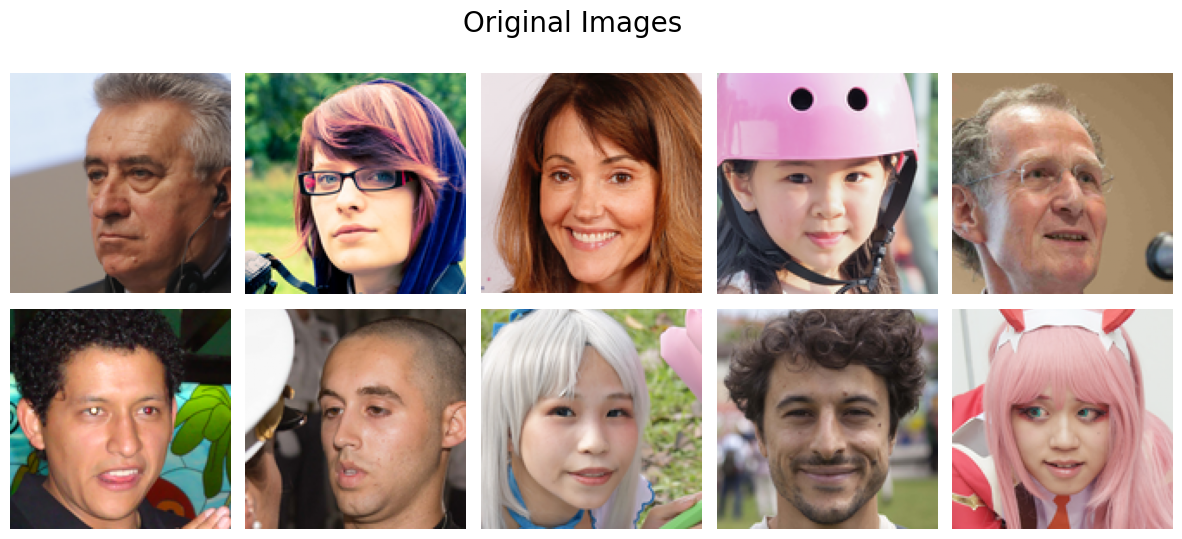

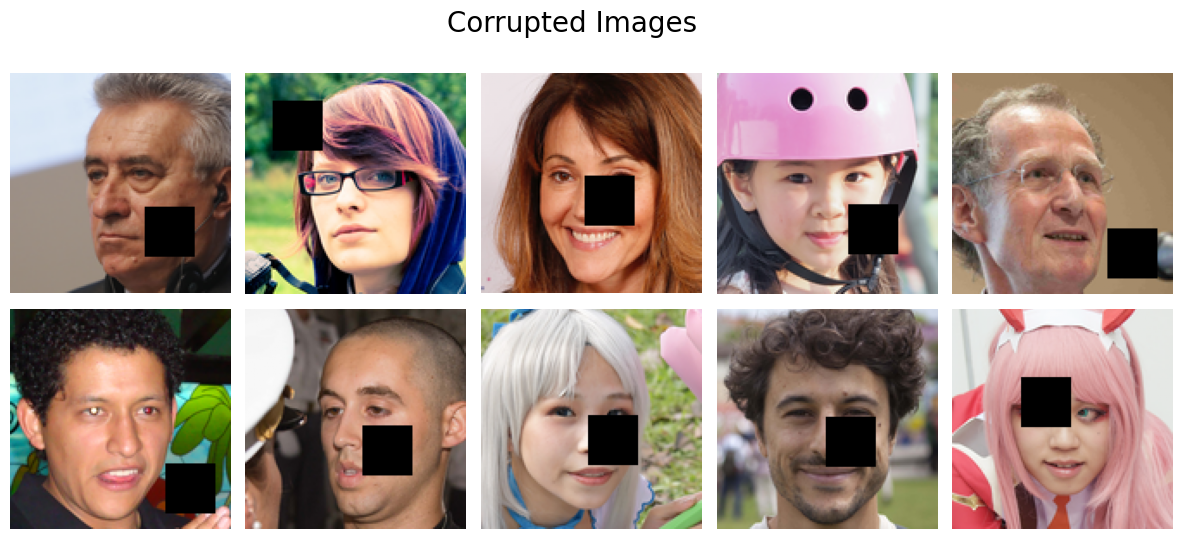

In [8]:
# get first batch of images
(corrupted_images_batch, orig_images_batch) = next(test_generator)

# only displaying 10 images from both batch
display_image_grid1(orig_images_batch[:10], 2, 5, "Original Images")
display_image_grid1(corrupted_images_batch[:10], 2, 5, "Corrupted Images")

In [9]:
no_of_channels = 3
INPUT_DIM = (128,128,no_of_channels) 
Z_DIM = [20, 100, 300, 5000]

## Building the Model

In [10]:
ae_encoder = None
ae_encoder_output = None
ae_encoder_input = Input(shape = INPUT_DIM, dtype=np.float32)

num_conv = {0: {'filters': 128, 'kernel_size': 5, 'strides': 2},
            1: {'filters': 64, 'kernel_size': 3, 'strides': 2},
            2: {'filters': 32, 'kernel_size': 3, 'strides': 2}}

encoder = ae_encoder_input
for layer_num,layer_data in num_conv.items():
  encoder = Conv2D(layer_data['filters'], layer_data['kernel_size'], layer_data['strides'], padding='same')(encoder)
  encoder = MaxPool2D((2,2),padding='same')(encoder)
  encoder = LeakyReLU(alpha=0.2)(encoder)
  encoder = BatchNormalization(axis=-1)(encoder)


volumeSize = K.int_shape(encoder)
flatten = Flatten()(encoder)
ae_encoder_output = Dense(Z_DIM[2])(flatten)
ae_encoder = Model(ae_encoder_input,ae_encoder_output)

ae_encoder.summary()
tf.keras.utils.plot_model(ae_encoder, show_shapes=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 128)       9728      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 128)      0         
 )                                                               
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        73792 

#### Decoder


In [12]:
ae_decoder = None
ae_decoder_output = None
ae_decode_input = Input(shape=(Z_DIM[2],))

decoder = Dense(np.prod(volumeSize[1:]))(ae_decode_input)
decoder = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(decoder)
for layer_num,layer_data in reversed(sorted(num_conv.items())):
  decoder = Conv2DTranspose(layer_data['filters'], layer_data['kernel_size'], layer_data['strides'], padding='same')(decoder)
  decoder = UpSampling2D(size=(2,2))(decoder)
  decoder = LeakyReLU(alpha=0.2)(decoder)
  decoder = BatchNormalization(axis=-1)(decoder)


decoder = Conv2DTranspose(no_of_channels, 3, padding='same')(decoder)
ae_decoder_output = Activation('sigmoid')(decoder)

ae_decoder = Model(ae_decode_input, ae_decoder_output)

ae_decoder.summary()
tf.keras.utils.plot_model(ae_decoder, show_shapes=True)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300)]             0         
                                                                 
 dense_1 (Dense)             (None, 128)               38528     
                                                                 
 reshape (Reshape)           (None, 2, 2, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 32)         9248      
 nspose)                                                         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 8, 8, 32)          0   

#### Attaching the Decoder to the Encoder

Finally, here we connect the encoder to the docoder.

In [13]:
autoencoder_model = None

autoencoder_input = ae_encoder_input
autoencoder_output =  ae_decoder(ae_encoder(ae_encoder_input))


autoencoder_model = Model(autoencoder_input, autoencoder_output)


autoencoder_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 model (Functional)          (None, 300)               141580    
                                                                 
 model_1 (Functional)        (None, 128, 128, 3)       275555    
                                                                 
Total params: 417,135
Trainable params: 416,239
Non-trainable params: 896
_________________________________________________________________


## Training the AE



## <b>Model trained with Hyperparameters listed below:  Best Results</b>
1. latent space: 300
2. epochs: 50
3. learning rate: 0.001
4. Batch size: 64
5. optimzer: adam
6. loss: mse


epoch :  100  lr :  0.001  batch size :  64  optim :  Adam  loss:  mse
Epoch 1/100


2024-05-02 23:22:42.327060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-05-02 23:22:42.337577: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


843/843 [==============================] - 792s 937ms/step - loss: 0.0251 - accuracy: 0.7884
Epoch 2/100
843/843 [==============================] - 796s 943ms/step - loss: 0.0173 - accuracy: 0.8184
Epoch 3/100
843/843 [==============================] - 794s 942ms/step - loss: 0.0156 - accuracy: 0.8235
Epoch 4/100
843/843 [==============================] - 792s 938ms/step - loss: 0.0147 - accuracy: 0.8258
Epoch 5/100
843/843 [==============================] - 795s 942ms/step - loss: 0.0141 - accuracy: 0.8269
Epoch 6/100
843/843 [==============================] - 795s 942ms/step - loss: 0.0137 - accuracy: 0.8317
Epoch 7/100
843/843 [==============================] - 794s 941ms/step - loss: 0.0133 - accuracy: 0.8364
Epoch 8/100
843/843 [==============================] - 792s 939ms/step - loss: 0.0130 - accuracy: 0.8393
Epoch 9/100
843/843 [==============================] - 793s 940ms/step - loss: 0.0128 - accuracy: 0.8411
Epoch 10/100
843/843 [==============================] - 788s 934ms/

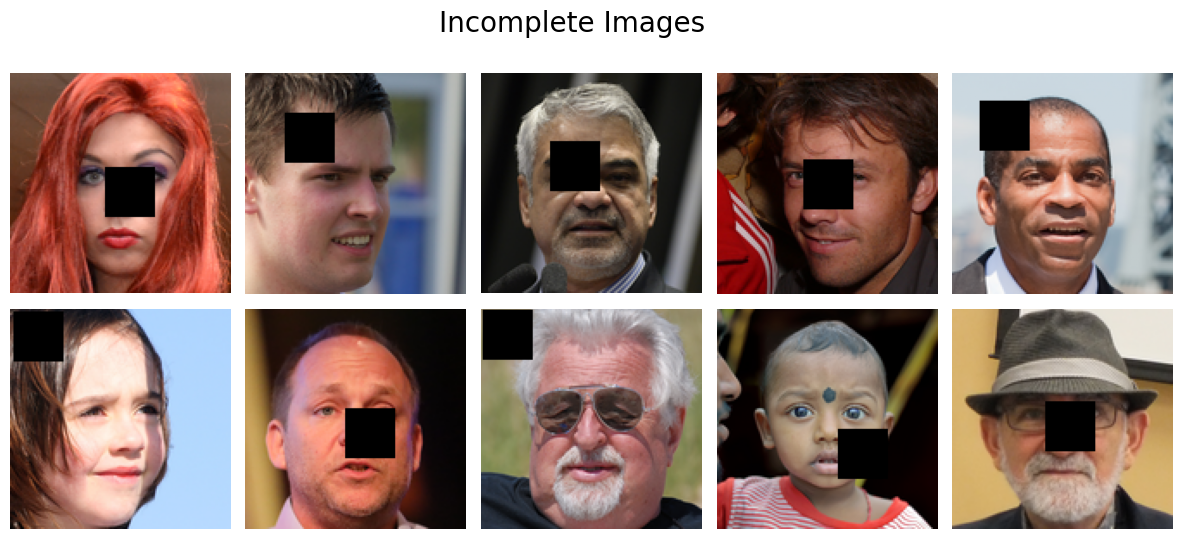

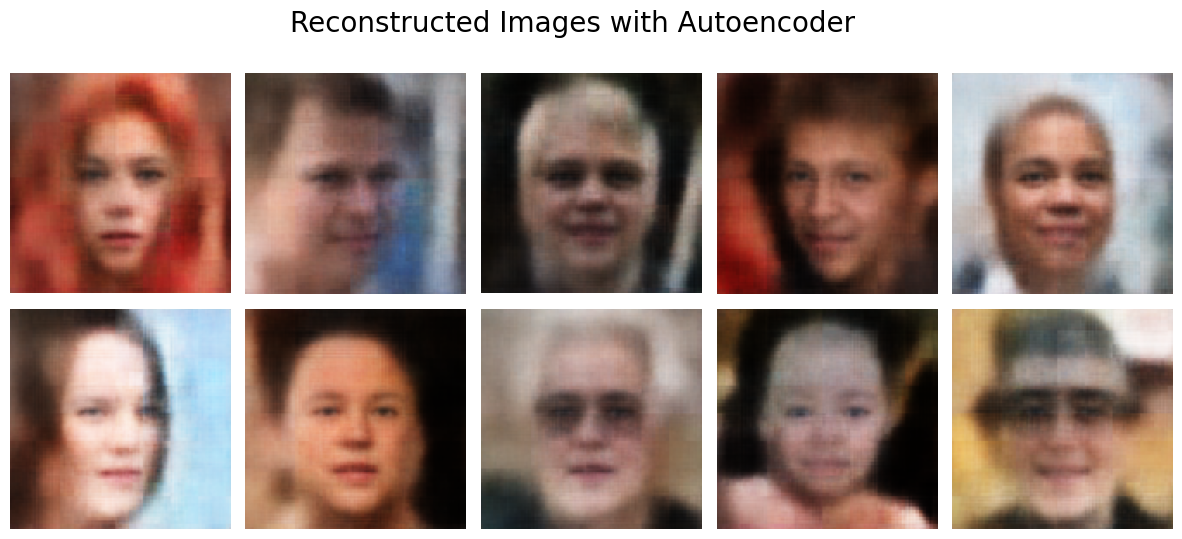

In [14]:
BATCH_SIZE = [64]   
N_EPOCHS = [100]      
LEARNING_RATE = [0.001]    
OPTIMIZERS = [Adam()]
LOSS = ['mse']

model = 0
save_model_paths = []
for batch_size in BATCH_SIZE:
  for epoch in N_EPOCHS:
    for learning_rate in LEARNING_RATE:
      for optimizer in OPTIMIZERS:
        for k_loss in LOSS:
          optim = optimizer
          print('epoch : ', epoch, ' lr : ', learning_rate, ' batch size : ', batch_size, ' optim : ', optim.get_config()['name'], ' loss: ', k_loss)
          train_generator = custom_image_generator(filenames, NUM_IMAGES, batch_size)
          optim.learning_rate = learning_rate
          autoencoder_model.compile(loss=k_loss, optimizer=optim, metrics='accuracy')
          autoencoder_model.fit(train_generator, steps_per_epoch=NUM_IMAGES /batch_size, epochs=epoch)


          test_gen = custom_image_generator(filenames, NUM_IMAGES)
          test_batch = next(test_gen)[0]
          test_images = test_batch[:10]
          reconst_images = autoencoder_model.predict(test_images)

          display_image_grid1(test_images, 2, 5, "Incomplete Images")
          display_image_grid2(reconst_images, 2, 5, "Reconstructed Images with Autoencoder")


          model_to_json = autoencoder_model.to_json()
          autoencoder_model.save("autoencoder_model_100.h5")




In [ ]:
# import cv2
# folder_path = "/content/output_images"

# image_files = glob(os.path.join(folder_path, "*.png"))

# # Load and display each image
# for img in image_files:

#     img1=cv2.imread(img)
#     cv2_imshow(img1)
#     predictions1 = emotion_detector.detect_emotions(img1)
#     print(predictions1)

#     #print("Predicted Emotion:", highest_emotion2)

In [ ]:
# analysis = emotion_detector.detect_emotions("/content/test.png")
# print("Predicted Emotion:", analysis)